In [1]:
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers.optimization import Adafactor, AdafactorSchedule
from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric
from sklearn.model_selection import train_test_split
import json
import torch

In [2]:
NUM_LABELS = 5

model_name = "neuralmind/bert-base-portuguese-cased"

In [3]:
ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}


def create_index_column(df):
    df["id"] = df.index + 1

def load_dataset():
    
    df_text = pd.DataFrame(pd.read_excel(os.path.join('./dataset', 'OpArticles.ods')))

    df_adu = pd.DataFrame(
        pd.read_excel(os.path.join('./dataset', 'aug.ods')))
    
    create_index_column(df_adu)
    
    return df_adu, df_text



def remove_dataframe_rows_by_id(df_to_remove, list_ids_to_remove):
    df_to_remove.set_index("id", inplace=True)

    df_to_remove.drop(list_ids_to_remove, inplace=True)

    df_to_remove.reset_index(inplace=True)


def split_train_test(df):
    
    train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    
    
    val, test = train_test_split(test, test_size=0.3, random_state=42, stratify=test['label'])

    train = pd.DataFrame.from_dict(train)
    
    val = pd.DataFrame.from_dict(val)
    
    test = pd.DataFrame.from_dict(test)
    
    return train, val, test
    
def outlier_detection(df_adu):
    results = {}
    dict_collisions = {}
    for _, row in df_adu.iterrows():
        if row['article_id'] not in results.keys():
            results[row['article_id']] = {
                'A': [],
                'B': [],
                'C': [],
                'D': []
            }

        if row['annotator'] == 'A':
            results[row['article_id']]['A'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

        elif row['annotator'] == 'B':
            results[row['article_id']]['B'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

        elif row['annotator'] == 'C':
            results[row['article_id']]['C'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

        elif row['annotator'] == 'D':
            results[row['article_id']]['D'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

    for article_id in results.keys():

        for adu_A in results[article_id]['A']:
            adu_matching(adu_A, results[article_id]['B'], results[article_id]['C'], results[article_id]['D'],
                         dict_collisions)
        for adu_B in results[article_id]['B']:
            adu_matching(adu_B, results[article_id]['A'], results[article_id]['C'], results[article_id]['D'],
                         dict_collisions)
        for adu_C in results[article_id]['C']:
            adu_matching(adu_C, results[article_id]['A'], results[article_id]['B'], results[article_id]['D'],
                         dict_collisions)
        for adu_D in results[article_id]['D']:
            adu_matching(adu_D, results[article_id]['A'], results[article_id]['B'], results[article_id]['C'],
                         dict_collisions)

    return dict_collisions


def adu_matching(adu, list_annotater_X, list_annotater_Y, list_annotater_Z, dict_collisions):
    for iterator in [list_annotater_X, list_annotater_Y, list_annotater_Z]:
        for elem in iterator:
            if json.loads(adu['ranges'])[0][0] < json.loads(elem['ranges'])[0][0] < json.loads(adu['ranges'])[0][1]:
                if adu['label'] != elem['label']:
                    # print(f"Disagreement between:\n{adu['tokens']} \n and \n {elem['tokens']}")
                    if adu['id'] not in dict_collisions.keys():
                        dict_collisions[adu['id']] = [elem['id']]
                    else:
                        dict_collisions[adu['id']].append(elem['id'])


def deal_with_outliers(df_adu, dict_collisions, option='delete'):
    # print(f"Before:{df_adu.describe()}")

    if option == 'delete':
        list_to_remove = []

        for key_left in dict_collisions.keys():
            list_to_remove.append(key_left)
            for elem in dict_collisions[key_left]:
                list_to_remove.append(elem)

        remove_dataframe_rows_by_id(df_adu, list_to_remove)

    elif option == 'majority':
        list_to_remove = []
        for key_left in dict_collisions.keys():
            counters = {
                'Fact': 0,
                'Policy': 0,
                'Value': 0,
                'Value(+)': 0,
                'Value(-)': 0,
            }

            majority_vote = None
            number_votes = 0

            adu = df_adu.loc[df_adu['id'] == key_left].iloc[0]

            counters[adu['label']] += 1

            for elem in dict_collisions[key_left]:
                adu = df_adu.loc[df_adu['id'] == elem].iloc[0]
                counters[adu['label']] += 1

            for elem in counters.keys():
                number_votes += counters[elem]

            """
            Find the majority vote type
            Majority_Vote returns a Valid Label
            """

            for elem in counters.keys():
                if counters[elem] / number_votes >= 0.5:
                    majority_vote = elem
                    break

            if not majority_vote:
                continue

            if adu['label'] != majority_vote:
                list_to_remove.append(adu['id'])

            for elem in dict_collisions[key_left]:
                elem_adu = df_adu.loc[df_adu['id'] == elem].iloc[0]
                if elem_adu['label'] != majority_vote:
                    list_to_remove.append(elem_adu['id'])

        remove_dataframe_rows_by_id(df_adu, list_to_remove)

    # print(f"After:{df_adu.describe()}")
#ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}   
def augment_train(df_train):
    new_lines={
        'tokens':[],
        'label':[],
    }
    for _, row in df_train.iterrows():
        #if row['label'] == 1 or row['label'] == 4:
        if row['label'] == 4 :
            correct_str = row['augmented']
            
            en_str = row['en']
            sp_str = row['sp']
            
            if not row['tokens'][0].isupper():
                correct_str = correct_str[0].lower() + correct_str[1:]
                en_str = en_str[0].lower() + en_str[1:]
                sp_str = sp_str[0].lower() + sp_str[1:]
                        
            new_lines['tokens'].append(correct_str)
            new_lines['label'].append(row['label'])
            #new_lines['tokens'].append(en_str)
            #new_lines['label'].append(row['label'])
            #new_lines['tokens'].append(sp_str)
            #new_lines['label'].append(row['label'])
        
    df = pd.DataFrame(new_lines)
    
    return df_train.append(df, ignore_index = True)

def clean_duplicates(df_adu):
    print(f"Before: {len(df_adu)}")
    
    new_lines={
        'tokens':[],
        'label':[],
    }
    
    for index, row in df_adu.iterrows():
        
        if len(df_adu[df_adu['tokens']==row['tokens']])==1:
            new_lines['tokens'].append(row['tokens'])
            new_lines['label'].append(row['label'])
        elif row['label'] != 0:
            if row['tokens'] not in new_lines['tokens']:
                new_lines['tokens'].append(row['tokens'])
                new_lines['label'].append(row['label'])
    
    
    df_adu = pd.DataFrame(new_lines)   
    
    print(f"After: {len(df_adu)}")
    
    return df_adu 

In [4]:
def tokenize_function(example):
    return tokenizer(example["tokens"], padding=True)

In [5]:
df_adu, _ = load_dataset()

train, val, test = split_train_test(df_adu)

dict_collisions = outlier_detection(train)

deal_with_outliers(train, dict_collisions, 'delete')

train.drop(columns=['article_id', 'annotator', 'node', 'ranges', 'id'], inplace = True)
train.replace(ENCODING, inplace=True)
train.reset_index(drop=True, inplace=True)

val.drop(columns=['article_id', 'annotator', 'node', 'ranges', 'id', 'sp', 'augmented', 'en'], inplace = True)
val.replace(ENCODING, inplace=True)
val.reset_index(drop=True, inplace=True)

test.drop(columns=['article_id', 'annotator', 'node', 'ranges', 'id', 'sp', 'augmented', 'en'], inplace = True)
test.replace(ENCODING, inplace=True)
test.reset_index(drop=True, inplace=True)

train = augment_train(train)

train.drop(columns=['sp', 'augmented', 'en'], inplace = True)

#train = clean_duplicates(train)

In [6]:
train_valid_test_dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'validation': Dataset.from_pandas(val),
    'test': Dataset.from_pandas(test)
})


tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = NUM_LABELS)

tokenized_dataset = train_valid_test_dataset.map(tokenize_function, batched=True)

max_layer = 11
#max_layer = 24

for name, param in model.named_parameters():
    for elem in range(max_layer-5):
        if name.startswith(f"bert.encoder.layer.{elem}."): # choose whatever you like here
            param.requires_grad = False

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [7]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', np.unique(train['label']),np.array(train['label']))

print(weights)

[0.42225627 2.51379704 1.20010887 0.98244207 2.61208531]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[3 2 0 ... 4 4 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [8]:
#ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        #loss_fct = nn.CrossEntropyLoss()
        #loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor([0.144841791087912, 0.36597554029858, 0.19756812689478, 0.1785916532763, 0.41302288844243]))
        loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor([0.044841791087912, 0.36597554029858, 0.09756812689478, 0.0785916532763, 0.41302288844243]))
        #loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor([0.0083380112344987, 0.062851882499246, 0.017616001354013, 0.014306433866884, 0.89688767104536]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



def compute_metrics(eval_pred):
    metric = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_val = metric.compute(predictions=predictions, references=labels, average='macro')

    metric = load_metric("accuracy")
    acc_val = metric.compute(predictions=predictions, references=labels)

    return {
        'f1':f1_val['f1'],
        'accuracy':acc_val['accuracy'],
    }

optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)

lr_scheduler = AdafactorSchedule(optimizer)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_strategy="epoch",
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="no",
    fp16=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
Using amp half precision backend


In [9]:
trainer.train()
trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 11023
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 865


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.581600,1.534647,0.074824,0.092150
2,1.275700,1.195450,0.295517,0.295506
3,0.923800,0.985746,0.476445,0.465017
4,0.750200,0.969085,0.541806,0.543515
5,0.644100,0.975895,0.540859,0.541524


Trainer is attempting to log a value of "7.229083621496102e-06" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3516
  Batch size = 16
Trainer is attempting to log a value of "1.458576662116684e-05" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSeque

{'eval_loss': 0.975895345211029,
 'eval_f1': 0.5408591846213371,
 'eval_accuracy': 0.5415244596131968,
 'eval_runtime': 8.6548,
 'eval_samples_per_second': 406.25,
 'eval_steps_per_second': 25.419,
 'epoch': 5.0}

In [10]:
max_layer = 11
#max_layer = 24

for name, param in model.named_parameters():
    for elem in range(max_layer):
        param.requires_grad = True

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_strategy="epoch",
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="no",
    fp16=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [11]:
trainer.train()
trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 11023
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 346


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.541800,1.120173,0.550459,0.553185
2,0.471500,1.129940,0.539963,0.550057


Trainer is attempting to log a value of "4.393010385683738e-05" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3516
  Batch size = 16
Trainer is attempting to log a value of "5.124660310684703e-05" of type <class 'torch.Tensor'> for key "train/learning_rate" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSeque

{'eval_loss': 1.129940390586853,
 'eval_f1': 0.539963188969443,
 'eval_accuracy': 0.550056882821388,
 'eval_runtime': 8.6836,
 'eval_samples_per_second': 404.903,
 'eval_steps_per_second': 25.335,
 'epoch': 2.0}

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1507
  Batch size = 16


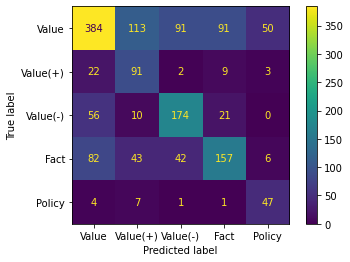

In [17]:

#ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions=trainer.predict(test_dataset=tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)
confusion_matrix = metrics.confusion_matrix(tokenized_dataset['test']['label'], preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Value","Value(+)","Value(-)","Fact","Policy"])
disp.plot()
#print(confusion_matrix)
plt.show()

In [13]:
"""
!pip install odfpy
!pip install ipywidgets widgetsnbextension pandas-profiling
!pip install datasets
!pip install transformers
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu110
"""

'\n!pip install odfpy\n!pip install ipywidgets widgetsnbextension pandas-profiling\n!pip install datasets\n!pip install transformers\n!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu110\n'

In [14]:
torch.cuda.empty_cache()
#!nvidia-smi